In [78]:
import warnings
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as statsmodels

from pandas import DataFrame, Series
from typing import Optional
from datetime import datetime

warnings.filterwarnings("ignore")


In [21]:
URL = (
    "https://course-resources.minerva.edu/uploaded_files/mu/00294342-2873/diabetes.csv"
)

X = "BMI"
Xs = ["BMI", "Glucose", "BloodPressure"]

Y = "SkinThickness"


In [ ]:
def preprocess_df(df: DataFrame) -> DataFrame:
    return df[(df[X] != 0) & (df[Y] != 0)]


In [ ]:
def get_figure_filename(name: str) -> str:
    now = datetime.now()
    return f"figures/{now.strftime('%Y%m%d%H%M%S')}-{name}.png"


In [5]:
df = preprocess_df(pd.read_csv(URL))


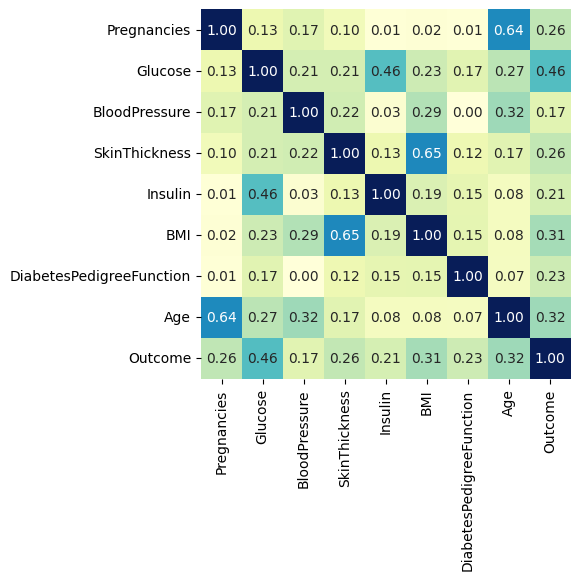

In [32]:
def plot_correlation_matrix(df: DataFrame, name: Optional[str] = None):
    sns.heatmap(
        df.corr().abs(),
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        cbar=False,
        square=True,
    )

    plt.savefig(get_figure_filename(name or "correlation-matrix"), dpi=600)
    plt.show()


plot_correlation_matrix(df)


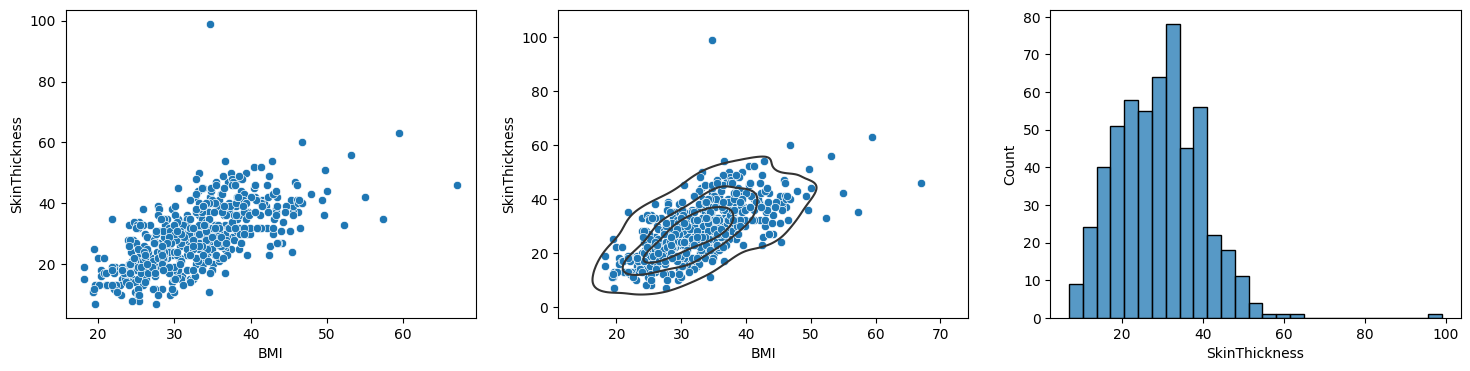

In [66]:
def plot_scatter(x: Series, y: Series, name: Optional[str] = None):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 4))

    sns.scatterplot(x=x, y=y, ax=ax1)

    sns.scatterplot(x=x, y=y, ax=ax2)
    sns.kdeplot(x=x, y=y, ax=ax2, levels=4, color=".2")

    sns.histplot(y, ax=ax3)

    plt.savefig(get_figure_filename(name or "scatter"), dpi=600)
    plt.show()


plot_scatter(df[X], df[Y])


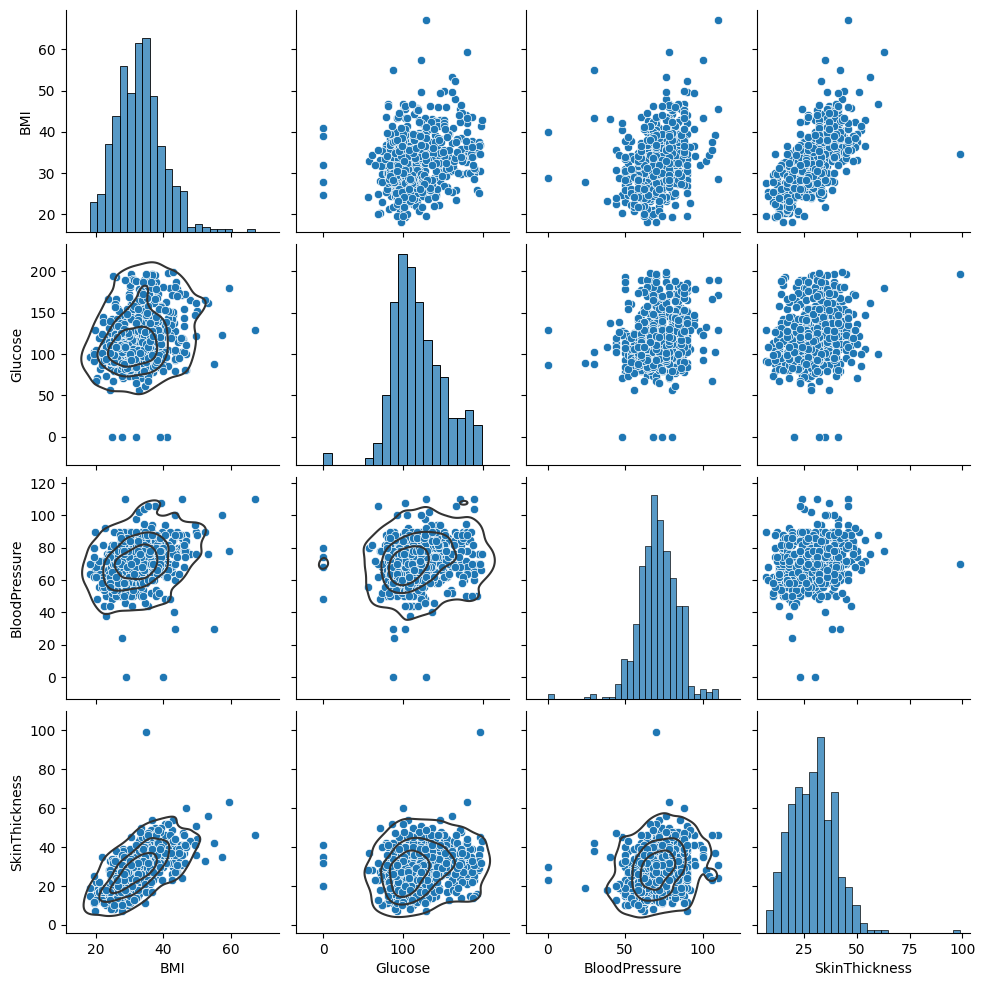

In [34]:
def plot_scatter_matrix(df: DataFrame, name: Optional[str] = None):
    plot = sns.pairplot(df)
    plot.map_lower(sns.kdeplot, levels=4, color=".2")
    plt.savefig(get_figure_filename(name or "scatter-matrix"), dpi=600)
    plt.show()


plot_scatter_matrix(df[[*Xs, Y]])


In [75]:
def simple_regression(
    x: Series,
    y: Series,
    plot: bool = False,
    plot_name: Optional[str] = None,
    summary: bool = False,
) -> tuple[float, float, float]:
    _x = statsmodels.add_constant(x)
    model = statsmodels.OLS(y, _x)
    results = model.fit()

    if summary:
        print(results.summary())

    r_squared = results.rsquared
    b_0, b_1 = results.params

    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 4))

        # ax1: scatter
        sns.regplot(x=x, y=y, marker="+", ax=ax1)

        # ax2: residuals
        sns.residplot(x=x, y=y, ax=ax2)
        ax2.set(
            ylabel="Residuals",
            xlabel="Fitted values",
            title=f"R^2 = {r_squared:.2f}",
            ylim=(min(results.resid) - 1, max(results.resid) + 1),
        )

        # ax3: histogram
        sns.distplot(results.resid, kde=False, axlabel="Residuals", color="red", ax=ax3)

        plt.savefig(get_figure_filename(plot_name or "simple-regression"), dpi=600)
        plt.show()

    return r_squared, b_0, b_1


# r_squared, b_0, b_1 = simple_regression(df[X], df[Y], plot=True)
r_squared, b_0, b_1 = simple_regression(df[X], df[Y], summary=True)


                            OLS Regression Results                            
Dep. Variable:          SkinThickness   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     389.2
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           1.47e-65
Time:                        18:38:47   Log-Likelihood:                -1884.3
No. Observations:                 539   AIC:                             3773.
Df Residuals:                     537   BIC:                             3781.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.3735      1.686     -2.001      0.0

In [76]:
def multiple_regression(
    x,
    y: Series,
    plot: bool = False,
    plot_name: Optional[str] = None,
    summary: bool = False,
) -> tuple[float, float, list[float]]:
    x = statsmodels.add_constant(x)
    model = statsmodels.OLS(y, x)
    results = model.fit()

    if summary:
        print(results.summary())

    residuals = results.resid
    r_squared = results.rsquared
    b_0, *b = results.params

    y_hat = results.predict()

    if plot:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

        # ax1: residual
        residuals_plot = sns.residplot(x=y_hat, y=residuals, color="green", ax=ax1)
        ax1.set(
            xlabel="Fitted values for y",
            ylabel="Residuals",
            title="Residuals vs Fitted values",
        )

        # ax2: qq
        qq_plot = statsmodels.qqplot(residuals, fit=True, line="45", ax=ax2)
        ax2.set(
            xlabel="Theoretical Quantiles",
            ylabel="Sample Quantiles",
            title='Normal Probability ("QQ") Plot for Residuals',
        )

        plt.savefig(get_figure_filename(plot_name or "multiple-regression"), dpi=600)
        plt.show()

    return r_squared, b_0, b


# r_squared, b_0, b = multiple_regression(df[Xs], df[Y], plot=True)
r_squared, b_0, b = multiple_regression(df[Xs], df[Y], summary=True)


                            OLS Regression Results                            
Dep. Variable:          SkinThickness   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     131.7
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           7.11e-64
Time:                        18:39:53   Log-Likelihood:                -1882.2
No. Observations:                 539   AIC:                             3772.
Df Residuals:                     535   BIC:                             3789.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -6.0951      2.333     -2.612

In [74]:
def forward_selection(
    df: DataFrame,
    xs: list[str],
    y: str,
) -> tuple[list[str], float, float, list[float]]:
    best_r_squared = 0
    best_xs = None
    best_b_0 = None
    best_b = None

    for i in range(1, len(xs) + 1):
        for _xs in itertools.combinations(xs, i):
            r_squared, b_0, b = multiple_regression(df[list(_xs)], df[y])
            if r_squared > best_r_squared:
                best_r_squared = r_squared
                best_xs = _xs
                best_b_0 = b_0
                best_b = b

    return best_xs, best_r_squared, best_b_0, best_b  # type: ignore


columns: list[str] = list(df.columns)  # type: ignore
columns.remove(Y)

xs, r_squared, b_0, b = forward_selection(df, columns, Y)

print(xs, r_squared)


('Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome') 0.43511166347493035


In [80]:
def standard_error(x: Series, y: Series, r_squared: float, ddof=1) -> float:
    n = len(x)
    s_x = x.std(ddof=ddof)
    s_y = y.std(ddof=ddof)
    return (s_y / s_x) * np.sqrt((1 - r_squared) / (n - 2))


In [79]:
def p_value(x: Series, y: Series, beta_1: float, tails: int = 2) -> float:
    r_squared, b_0, b_1 = simple_regression(x, y)
    SE_b_1 = standard_error(x, y, r_squared)

    t = (b_1 - beta_1) / SE_b_1
    p: float = stats.t.sf(np.abs(t), n - 2) * tails  # type: ignore

    return p


p_value(
    df[X],
    df[Y],
    0,
    tails=2,
)


1.471921937796921e-65

In [ ]:
def confidence_interval(
    x: Series, y: Series, alpha: float = 0.05
) -> tuple[float, float]:
    r_squared, b_0, b_1 = simple_regression(x, y)
    SE_b_1 = standard_error(x, y, r_squared)

    t: float = stats.t.ppf(1 - alpha / 2, n - 2)  # type: ignore

    lower = b_1 - t * SE_b_1
    upper = b_1 + t * SE_b_1

    return lower, upper
